# Kuwait COVID19 Visualization & Prediction
> :heart:Kuwait COVID19 Visualization:heart_eyes and Prediction:fire:
- toc: true
- branch: master
- badges: false
- comments: false
- author: Nabeel Khan
- categories: [Kuwait, GCC, COVID-19, jupyter]
- image: images/Kuwait.jpg
- permalink: /Kuwait-COVID19-Visualization-and-Prediction/

> Based on the data by MoH Kuwait and WHO Database, we have only
> 52 Observations as of April 08th 2020

In [1]:
#hide
print('''
Learn more about how machine learning tools and techniques can help Govt. 
MoI, MoH, Labour and Work Force Dept. etc. 
Get professional consulting at https://www.nabeelkhan.com/contact/
''')


Learn more about how machine learning tools and techniques can help Govt. 
MoI, MoH, Labour and Work Force Dept. etc. 
Get professional consulting at https://www.nabeelkhan.com/contact/



In [2]:
#hide
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as py
import plotly.io as pio

from jinja2 import Template
from IPython.display import HTML
from urllib.request import urlopen
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, plot_mpl

pio.renderers.default = 'jupyterlab'# 'colab'
plotly.offline.init_notebook_mode(connected=True)
plt.rcParams.update({'font.size': 14})
pio.templates.default = 'plotly+presentation'

mpl.style.use('ggplot')
%matplotlib inline

In [3]:
#hide
from pathlib import Path
if not Path('covid_kuwait.py').exists():
    !wget https://raw.githubusercontent.com/nabeelkhan/COVID19/master/Dashboard/covid_kuwait.py

In [4]:
#hide
import covid_kuwait as covid

In [5]:
#hide

logo = 'https://raw.githubusercontent.com/isimplification/covid19.simplification.io/master/images/Logo-Text%40300x.png'

def add_rates(df):
    df['Confirmed Change'] = df['Confirmed'].diff().shift(1).fillna(0)
 
    df['Mortality Rate'] = df['Deaths'] / df['Confirmed'].fillna(0)#.round(1)
    df['Recovery Rate'] = df['Recoveries'] / df['Confirmed'].fillna(0)#.round(1)
    df['Growth Rate'] = df['Confirmed Change'] / df['Confirmed'].fillna(0)#.round(1)
    df['Growth Rate Change'] = df['Growth Rate'].diff().shift(1).fillna(0)#.round(1)
    df['Growth Rate Accel'] = df['Growth Rate Change'] / df['Growth Rate'].fillna(0)#.round(1)
    return df

k_layout_kwargs = {
    'font': dict(size=12,),
    'legend': dict(x=0, y=-0.7),
    #'paper_bgcolor': 'rgba(170, 0, 255, 0.03)',
    #'plot_bgcolor':'rgba(170, 0, 255, 0.03)',
    'images': [dict(
        source=logo, opacity=0.2, layer='below',
        xref="paper", yref="paper",
        x=0.15, y=0.70,
        sizex=0.3, sizey=0.2,
        xanchor="right", yanchor="bottom",)],
    'xaxis': dict(
        showticklabels=True,
        #tick0=0,# tickwidth=1,
        showgrid=False,
        showline=True,
        zeroline=False,
        #gridcolor='rgba(102, 102, 102, 0.4)',
        #gridwidth=1,
        linecolor='royalblue', linewidth=1,            
        mirror=True,
    ),
    'yaxis': dict(
        anchor='x',
        #gridcolor='rgba(102, 102, 102, 0.4)', 
        #gridwidth=1,
        linecolor='royalblue', linewidth=1,
        mirror=True,
        showgrid=False,
        showline=True,
        zeroline=False,
        showticklabels=True,
        tick0=0,
        #dtick=0.1,
        #tickformat=".2%",
    ),
}

In [6]:
#hide

COL_REGION = 'Country/Region'
# Confirmed, Recovered, Deaths
df = covid.get_frame('confirmed')
# dft_: timeseries, dfc_: today country agg
dft_cases = df
dft_deaths = covid.get_frame('deaths')
dft_recovered = covid.get_frame('recovered')
LAST_DATE_I, dt_cols = covid.get_dates(df)

dt_today = dt_cols[LAST_DATE_I]
dt_3ago = dt_cols[LAST_DATE_I-3]
dt_5ago = dt_cols[LAST_DATE_I-5]
dt_7ago = dt_cols[LAST_DATE_I-7]

dfc_cases = dft_cases.groupby(COL_REGION)[dt_today].sum()
dfc_deaths = dft_deaths.groupby(COL_REGION)[dt_today].sum()
dfc_recovered = dft_recovered.groupby(COL_REGION)[dt_today].sum()

dfo_cases = dft_cases.groupby(COL_REGION)[dt_3ago].sum()
dfo_deaths = dft_deaths.groupby(COL_REGION)[dt_3ago].sum()
dfo_recovered = dft_recovered.groupby(COL_REGION)[dt_3ago].sum()

dfp_cases = dft_cases.groupby(COL_REGION)[dt_5ago].sum()
dfp_deaths = dft_deaths.groupby(COL_REGION)[dt_5ago].sum()
dfp_recovered = dft_recovered.groupby(COL_REGION)[dt_5ago].sum()

dfq_cases = dft_cases.groupby(COL_REGION)[dt_7ago].sum()
dfq_deaths = dft_deaths.groupby(COL_REGION)[dt_7ago].sum()
dfq_recovered = dft_recovered.groupby(COL_REGION)[dt_7ago].sum()

In [7]:
from datetime import datetime
dt_todayf = datetime.strptime(dt_today, '%m/%d/%y').date()
print(dt_todayf.strftime("%A, %B %d, %Y"))

Sunday, April 12, 2020


In [8]:
#hide

df_table = (pd.DataFrame(dict(Cases=dfc_cases, Deaths=dfc_deaths, Recovered=dfc_recovered,
                              PCases=dfo_cases, PDeaths=dfo_deaths, PRecovered=dfo_recovered,
                              Cases_5=dfp_cases, Deaths_5=dfp_deaths, Recovered_5=dfp_recovered, 
                              Cases_7=dfq_cases, Deaths_7=dfq_deaths, Recovered_7=dfq_recovered))
             .sort_values(by=['Cases', 'Recovered'], ascending=[False, False])
             .reset_index())
df_table.rename(columns={'index': 'Country/Region'}, inplace=True)
for c in 'Cases, Recovered, Deaths'.split(', '):
    df_table[f'{c} (+)'] = (df_table[c] - df_table[f'P{c}']).clip(0)  # DATA BUG
    df_table[f'{c} 5(+)'] = (df_table[c] - df_table[f'{c}_5']).clip(0)  # DATA BUG
    df_table[f'{c} 7(+)'] = (df_table[c] - df_table[f'{c}_7']).clip(0)  # DATA BUG    
    
df_table['Fatality Rate'] = (100 * df_table['Deaths'] / df_table['Cases']).round(1)
df_table['Recovery Rate'] = (100 * df_table['Recovered'] / df_table['Cases']).round(1)
df_table['Continent'] = df_table['Country/Region'].map(covid.mapping['map.continent'])
# df_table.head(15)

In [9]:
#hide
df_table[df_table['Country/Region'].isin(['Kuwait', 'Qatar', 'Bahrain', 'Oman', 'United Arab Emirates', 'Saudi Arabia'])]

df_table.loc[df_table['Country/Region'].isin(['Kuwait', 'Qatar', 'Bahrain', 'Oman', 'United Arab Emirates', 'Saudi Arabia']), 'Continent'] = 'GCC'

# arab_df = df_table[df_table['Continent'].isin(['GCC', 'Arab'])]

gcc_summary_df = df_table[df_table['Continent'].isin(['GCC'])]

In [10]:
#hide
# delete problematic countries from table
df_table = df_table[~df_table['Country/Region'].isin(['Cape Verde', 'Cruise Ship', 'Kosovo'])]

In [11]:
#hide
# GCC, KU, SA, AE, 
metrics = ['Cases', 'Recovered', 'Deaths', 'Cases (+)', 'Recovered (+)', 'Deaths (+)']
s_gcc = df_table[df_table['Continent'].eq('GCC')][metrics].sum().add_prefix('GCC ')
s_ku = df_table[df_table['Country/Region'].eq('Kuwait')][metrics].sum().add_prefix('KU ')
s_sa = df_table[df_table['Country/Region'].eq('Saudi Arabia')][metrics].sum().add_prefix('SA ')
s_ae = df_table[df_table['Country/Region'].eq('United Arab Emirates')][metrics].sum().add_prefix('AE ')


summary = {'updated': pd.to_datetime(dt_today), 'since': pd.to_datetime(dt_3ago)}
summary = {**summary, **gcc_summary_df[metrics].sum(), **s_gcc, **s_ku, **s_sa, **s_ae} #  
summary

{'updated': Timestamp('2020-04-12 00:00:00'),
 'since': Timestamp('2020-04-09 00:00:00'),
 'Cases': 14533,
 'Recovered': 2525,
 'Deaths': 99,
 'Cases (+)': 3626,
 'Recovered (+)': 646,
 'Deaths (+)': 26,
 'GCC Cases': 14533,
 'GCC Recovered': 2525,
 'GCC Deaths': 99,
 'GCC Cases (+)': 3626,
 'GCC Recovered (+)': 646,
 'GCC Deaths (+)': 26,
 'KU Cases': 1234,
 'KU Recovered': 142,
 'KU Deaths': 1,
 'KU Cases (+)': 324,
 'KU Recovered (+)': 31,
 'KU Deaths (+)': 0,
 'SA Cases': 4462,
 'SA Recovered': 761,
 'SA Deaths': 59,
 'SA Cases (+)': 1175,
 'SA Recovered (+)': 95,
 'SA Deaths (+)': 15,
 'AE Cases': 4123,
 'AE Recovered': 680,
 'AE Deaths': 22,
 'AE Cases (+)': 1133,
 'AE Recovered (+)': 412,
 'AE Deaths (+)': 8}

In [12]:
#hide
# Overview 
dft_ct_cases = dft_cases.groupby(COL_REGION)[dt_cols].sum()
dft_ct_new_cases = dft_ct_cases.diff(axis=1).fillna(0).astype(int)
#dft_ct_new_cases.head(10)

In [13]:
#hide_input
# Overview 
template = Template(covid.get_template(covid.paths['kuwait']))
html = template.render(
    D=summary, 
    table=gcc_summary_df,  # REMOVE .head(20) to see all values
    newcases=dft_ct_new_cases.loc[:, dt_cols[LAST_DATE_I-50]:dt_cols[LAST_DATE_I]],
    np=np, pd=pd, enumerate=enumerate)
HTML(f'<div>{html}</div>')

In [14]:
#hide
confirmed_df = dft_cases # pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = dft_deaths # pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = dft_recovered # pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

# MOH Data Source
kuwait_MOD_df = pd.read_csv('https://raw.githubusercontent.com/nabeelkhan/COVID19/master/data/Time_Series_COVID19_Kuwait.csv')


# Drop date columns if they are mostly NaN
na_columns = (confirmed_df.isna().sum() / confirmed_df.shape[0]) > 0.99
na_columns = na_columns[na_columns]

confirmed_df = confirmed_df.drop(na_columns.index, axis=1)
deaths_df = deaths_df.drop(na_columns.index, axis=1)
recoveries_df = recoveries_df.drop(na_columns.index, axis=1)

## Tidy up the data
confirmed_df = confirmed_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='confirmed')
deaths_df = deaths_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='deaths')
recoveries_df = recoveries_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='recoveries')

# Date Conversion
confirmed_df['date'] = pd.to_datetime(confirmed_df['date'])
deaths_df['date'] = pd.to_datetime(deaths_df['date'])
recoveries_df['date'] = pd.to_datetime(recoveries_df['date'])
kuwait_MOD_df['Date'] = pd.to_datetime(kuwait_MOD_df['Date'])


# Full DataFrame -> Missing Canadian Details
full_df = confirmed_df.merge(recoveries_df).merge(deaths_df)
full_df = full_df.rename(columns={'Country/Region': 'Country', 'date': 'Date', 'confirmed': "Confirmed", "recoveries": "Recoveries", "deaths": "Deaths"})
# Check nulls
# full_df.isnull().sum()

In [15]:
#hide
full_df

,Country,Province/State,Lat,Long,Date,Confirmed,Recoveries,Deaths
0,Afghanistan,NaN,33.000000,65.000000,2020-01-22,0,0,0
1,Albania,NaN,41.153300,20.168300,2020-01-22,0,0,0
2,Algeria,NaN,28.033900,1.659600,2020-01-22,0,0,0
3,Andorra,NaN,42.506300,1.521800,2020-01-22,0,0,0
4,Angola,NaN,-11.202700,17.873900,2020-01-22,0,0,0
...,...,...,...,...,...,...,...,...
20167,France,Saint Pierre and Miquelon,46.885200,-56.315900,2020-04-12,1,0,0
20168,South Sudan,NaN,6.877000,31.307000,2020-04-12,4,0,0
20169,Western Sahara,NaN,24.215500,-12.885800,2020-04-12,6,0,0
20170,Sao Tome and Principe,NaN,0.186360,6.613081,2020-04-12,4,0,0


In [16]:
#hide
# World df = > Total by dates
world_df = full_df.groupby(['Date']).agg({'Confirmed': ['sum'], 'Recoveries': ['sum'], 'Deaths': ['sum']}).reset_index()
world_df.columns = world_df.columns.get_level_values(0)
world_df = add_rates(world_df)
world_df

,Date,Confirmed,Recoveries,Deaths,Confirmed Change,Mortality Rate,Recovery Rate,Growth Rate,Growth Rate Change,Growth Rate Accel
0,2020-01-22,555,28,17,0.0,0.030631,0.050450,0.000000,0.000000,NaN
1,2020-01-23,654,30,18,0.0,0.027523,0.045872,0.000000,0.000000,NaN
2,2020-01-24,941,36,26,99.0,0.027630,0.038257,0.105207,0.000000,0.000000
3,2020-01-25,1434,39,42,287.0,0.029289,0.027197,0.200139,0.105207,0.525670
4,2020-01-26,2117,52,56,493.0,0.026453,0.024563,0.232877,0.094932,0.407650
...,...,...,...,...,...,...,...,...,...,...
77,2020-04-08,1491926,324502,87929,79686.0,0.058937,0.217505,0.053411,-0.002884,-0.053996
78,2020-04-09,1574659,348808,94950,83732.0,0.060299,0.221513,0.053175,0.002155,0.040528
79,2020-04-10,1669619,370234,101966,82733.0,0.061071,0.221748,0.049552,-0.000237,-0.004779
80,2020-04-11,1748151,395513,107847,94960.0,0.061692,0.226246,0.054320,-0.003623,-0.066691


In [17]:
#hide
gcc_df = full_df[full_df['Country'].isin(['Kuwait', 'Qatar', 'Bahrain', 'Oman', 'United Arab Emirates', 'Saudi Arabia'])].reset_index(drop=True)
gcc_df.drop(['Province/State'], axis=1, inplace=True)

# Check rows where cases are 0
gcc_df[gcc_df["Confirmed"]==0].count()

# Drop rows where cases are 0
# gcc_df = gcc_df[gcc_df.Confirmed != 0].reset_index(drop=True)

#gcc_df = gcc_df.groupby(['Country', 'Date']).agg({'Confirmed': ['sum'], 'Recoveries': ['sum'], 'Deaths': ['sum']}).reset_index(drop=True)
gcc_df = gcc_df.groupby(['Country', 'Date']).agg({'Confirmed': ['sum'], 'Recoveries': ['sum'], 'Deaths': ['sum']}).reset_index()
gcc_df.columns = gcc_df.columns.get_level_values(0)
gcc_df = add_rates(gcc_df)

gcc_df = gcc_df.replace([np.inf, -np.inf], np.nan).fillna(0)

gcc_df

,Country,Date,Confirmed,Recoveries,Deaths,Confirmed Change,Mortality Rate,Recovery Rate,Growth Rate,Growth Rate Change,Growth Rate Accel
0,Bahrain,2020-01-22,0,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,Bahrain,2020-01-23,0,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,Bahrain,2020-01-24,0,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,Bahrain,2020-01-25,0,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,Bahrain,2020-01-26,0,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
487,United Arab Emirates,2020-04-08,2659,239,12,283.0,0.004513,0.089883,0.106431,-0.024196,-0.227338
488,United Arab Emirates,2020-04-09,2990,268,14,300.0,0.004682,0.089632,0.100334,-0.010992,-0.109550
489,United Arab Emirates,2020-04-10,3360,418,16,331.0,0.004762,0.124405,0.098512,-0.006097,-0.061886
490,United Arab Emirates,2020-04-11,3736,588,20,370.0,0.005353,0.157388,0.099036,-0.001823,-0.018403


In [18]:
#hide

ku_df = full_df[full_df['Country'].isin(['Kuwait'])].reset_index(drop=True)
ku_df.drop(['Province/State', 'Lat', 'Long'],axis=1, inplace=True)

# Check rows where cases are 0
ku_df[ku_df["Confirmed"]==0].count()

# Drop rows where cases are 0
ku_df = ku_df[(ku_df.Date > '22/02/2020')].reset_index(drop=True)


ku_df = ku_df.groupby(['Date']).agg({'Confirmed': ['sum'], 'Recoveries': ['sum'], 'Deaths': ['sum']}).reset_index()
ku_df.columns = ku_df.columns.get_level_values(0)

#ku_df = ku_df.sort_values(by=['Date'], ascending=False).reset_index(drop=True)

def add_rates(df):
    df['Confirmed Change'] = df['Confirmed'].diff().shift(1).fillna(0)
 
    df['Mortality Rate'] = df['Deaths'] / df['Confirmed'].fillna(0)#.round(1)
    df['Recovery Rate'] = df['Recoveries'] / df['Confirmed'].fillna(0)#.round(1)
    df['Growth Rate'] = df['Confirmed Change'] / df['Confirmed'].fillna(0)#.round(1)
    df['Growth Rate Change'] = df['Growth Rate'].diff().shift(1).fillna(0)#.round(1)
    df['Growth Rate Accel'] = df['Growth Rate Change'] / df['Growth Rate'].fillna(0)#.round(1)
    return df


ku_df = add_rates(ku_df)

ku_df = ku_df.replace([np.inf, -np.inf], np.nan).fillna(0)
# len(ku_df.index)
# ku_df.count()
# ku_df.shape
ku_df

,Date,Confirmed,Recoveries,Deaths,Confirmed Change,Mortality Rate,Recovery Rate,Growth Rate,Growth Rate Change,Growth Rate Accel
0,2020-02-23,0,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-02-24,1,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-02-25,11,0,0,1.0,0.000000,0.000000,0.090909,0.000000,0.000000
3,2020-02-26,26,0,0,10.0,0.000000,0.000000,0.384615,0.090909,0.236364
4,2020-02-27,43,0,0,15.0,0.000000,0.000000,0.348837,0.293706,0.841958
5,2020-02-28,45,0,0,17.0,0.000000,0.000000,0.377778,-0.035778,-0.094707
6,2020-02-29,45,0,0,2.0,0.000000,0.000000,0.044444,0.028941,0.651163
7,2020-03-01,45,0,0,0.0,0.000000,0.000000,0.000000,-0.333333,0.000000
8,2020-03-02,56,0,0,0.0,0.000000,0.000000,0.000000,-0.044444,0.000000
9,2020-03-03,56,0,0,11.0,0.000000,0.000000,0.196429,0.000000,0.000000


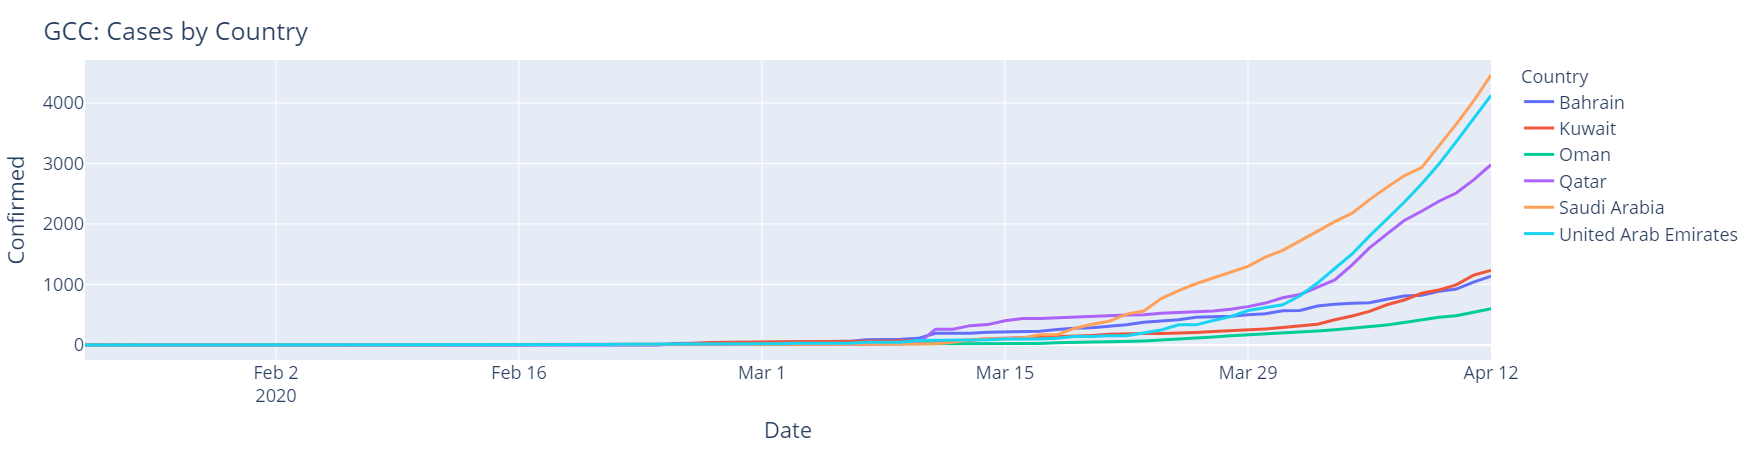

In [19]:
#hide_input

fig = px.line(gcc_df, x='Date', y='Confirmed', color='Country', line_group="Country", hover_name="Country")
fig.update_layout(
    title={'text': 'GCC: Cases by Country', 'y':0.95, 'x':0.1, 'xanchor': 'center', 'yanchor': 'top'},
    #**k_layout_kwargs,
)

fig.show()

In [20]:
#hide

gcc_3days = gcc_df.filter(['Country/Region','Cases','Recovered','Deaths','PCases','PRecovered','PDeaths','Cases (+)', 'Recovered (+)', 'Deaths (+)', 'Recovery Rate', 'Fatality Rate'])

gcc_5days = gcc_df.filter(['Country/Region','Cases','Recovered','Deaths','Cases_5','Recovered_5','Deaths_5','Cases 5(+)', 'Recovered 5(+)', 'Deaths 5(+)', 'Recovery Rate', 'Fatality Rate'])

gcc_7days = gcc_df.filter(['Country/Region','Cases','Recovered','Deaths','Cases_7','Recovered_7','Deaths_7','Cases 7(+)', 'Recovered 7(+)', 'Deaths 7(+)', 'Recovery Rate', 'Fatality Rate'])

gcc_3days = gcc_3days.rename(columns={'Country/Region': 'Country', 'PCases': 'Cases 3 Days', 'PDeaths': 'Deaths 3 Days', 'PRecovered': 'Recoveries 3 Days', 'Fatality Rate': 'Mortality Rate'})

gcc_5days = gcc_5days.rename(columns={'Country/Region': 'Country', 'Cases_5': 'Cases 5 Days', 'Deaths_5': 'Deaths 5 Days', 'Recovered_5': 'Recoveries 5 Days', 'Fatality Rate': 'Mortality Rate'})

gcc_7days = gcc_7days.rename(columns={'Country/Region': 'Country', 'Cases_7': 'Cases 7 Days', 'Deaths_7': 'Deaths 7 Days', 'Recovered_7': 'Recoveries 7 Days', 'Fatality Rate': 'Mortality Rate'})


In [21]:
#hide
# Canada df
confirmed_ca=confirmed_df[confirmed_df["Country/Region"]=="Canada"]
recoveries_ca=recoveries_df[recoveries_df["Country/Region"]=="Canada"]
deaths_ca=deaths_df[deaths_df["Country/Region"]=="Canada"]

ca_df = confirmed_ca.merge(recoveries_ca).merge(deaths_ca)
ca_df = ca_df.rename(columns={'Country/Region': 'Country', 'date': 'Date', 'confirmed': 'Confirmed', 'recoveries': 'Recoveries', 'deaths': 'Deaths'})

canada_df = ca_df.groupby(['Date']).agg({'Confirmed': ['sum'], 'Recoveries': ['sum'], 'Deaths': ['sum']}).reset_index()
canada_df.columns = canada_df.columns.get_level_values(0)

canada_df = add_rates(canada_df)

In [22]:
#hide
kuwait = ku_df.groupby(['Date']).agg({'Confirmed': ['sum'], 'Recoveries': ['sum'], 'Deaths': ['sum']}).reset_index()
kuwait.columns = kuwait.columns.get_level_values(0) 

kuwait = add_rates(kuwait)

## Kuwaiti Cases

In [23]:
#hide
def plot_aggregate_metrics(df, fig=None):
    if fig is None:
        fig = go.Figure()
    # Set options common to all traces with fig.update_traces
    # fig.update_traces(mode='markers', marker_line_width=2, marker_size=10)
    fig.add_trace(go.Scatter(x=df['Date'], 
                             y=df['Confirmed'],
                             mode='lines+markers',
                             name='Confirmed',
                             #line=dict(color='Yellow', width=2)
                            ))
    fig.add_trace(go.Scatter(x=df['Date'], 
                             y=df['Deaths'],
                             mode='lines+markers',
                             name='Deaths',
                             #line=dict(color='Red', width=2)
                            ))
    fig.add_trace(go.Scatter(x=df['Date'], 
                             y=df['Recoveries'],
                             mode='lines+markers',
                             name='Recoveries',
                             #line=dict(color='Green', width=2)
                            ))
    # Configure other layout properties
    fig.update_layout(
        title={'text': 'Total Kuwaiti Cases', 'y':0.9, 'x':0.1, 'xanchor': 'center', 'yanchor': 'top'},
        xaxis=dict(
            title='<i>Timeline <br>Data Source: WHO</i>',
        ),
        yaxis=dict(
            title='No. Of Cases',
        ),
    )
    return fig

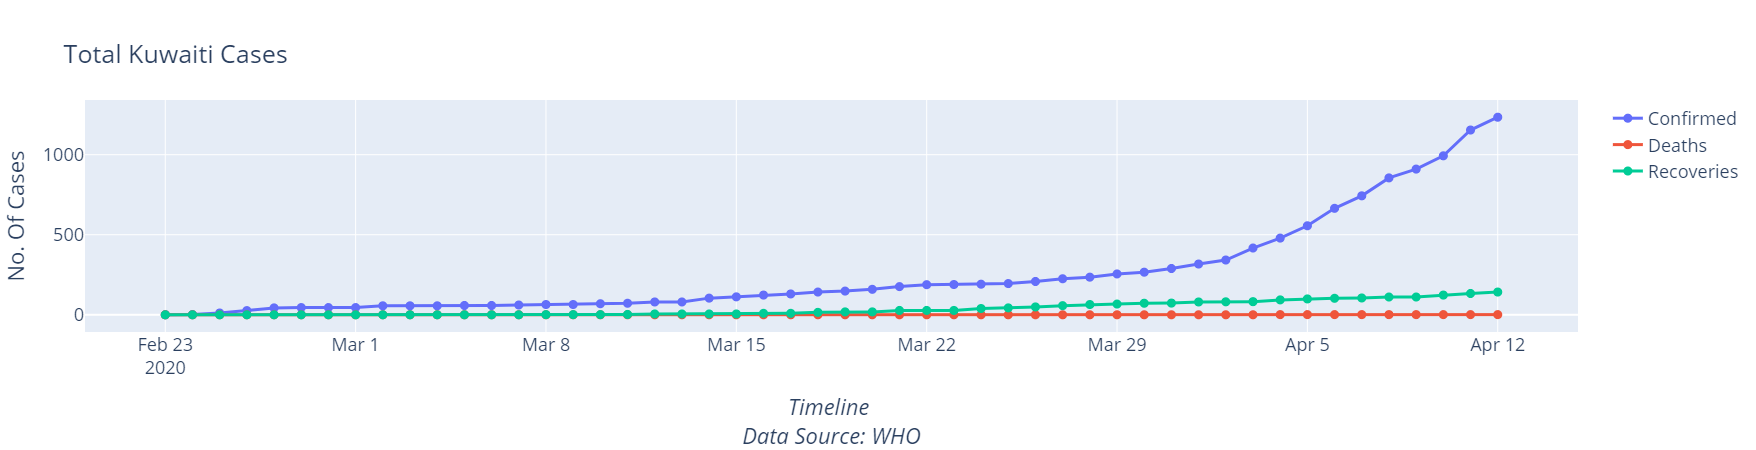

In [24]:
#hide_input
plot_aggregate_metrics(ku_df).show()

In [25]:
#hide
def plot_diff_metrics(df, fig=None):
    if fig is None:
        fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['Date'], 
                             y=df['Mortality Rate'],
                             mode='lines+markers',
                             name='Mortality rate',
                             #line=dict(color='red', width=2)
                            ))

    fig.add_trace(go.Scatter(x=df['Date'], 
                             y=df['Recovery Rate'],
                             mode='lines+markers',
                             name='Recovery rate',
                             #line=dict(color='Green', width=2)
                            ))

    fig.add_trace(go.Scatter(x=df['Date'], 
                             y=df['Growth Rate'],
                             mode='lines+markers',
                             name='Growth rate confirmed',
                             #line=dict(color='Yellow', width=2)
                            ))


    # Configure other layout properties
    fig.update_layout(
        title={'text': 'Kuwaiti Rates', 'y':0.9, 'x':0.1, 'xanchor': 'center', 'yanchor': 'top'},
        xaxis=dict(
            title='<i>Timeline <br>Data Source: WHO</i>',
        ),
        yaxis=dict(
            title='No. Of Cases',
        ),
    )
    return fig

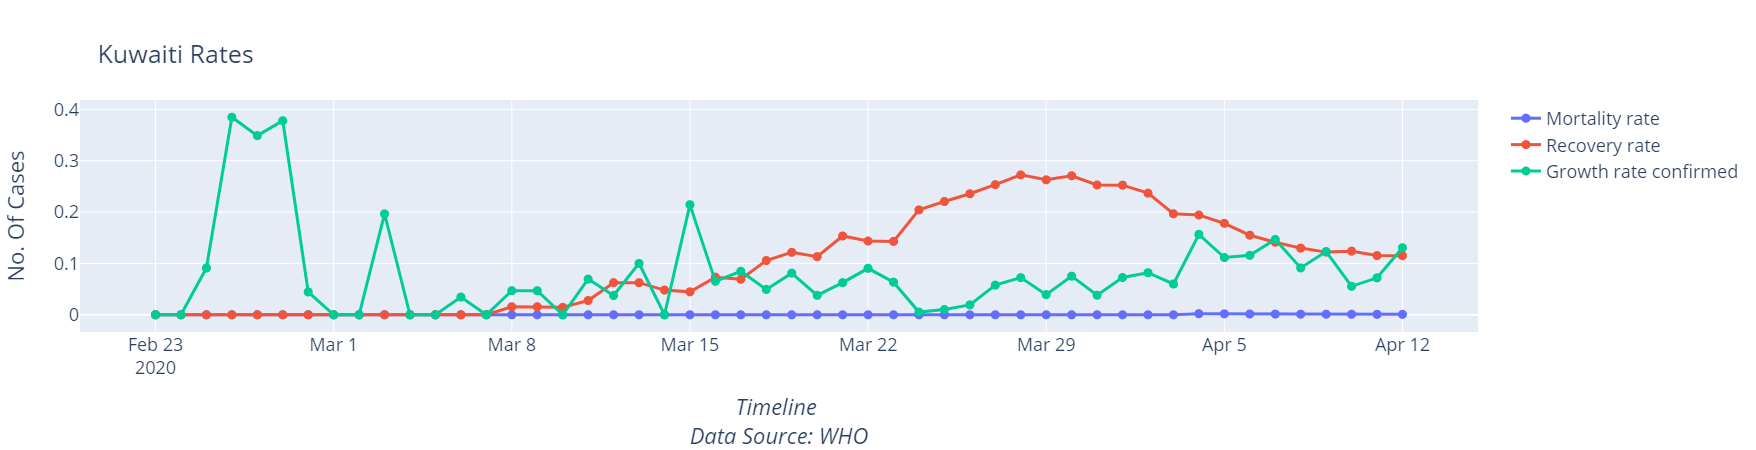

In [26]:
#hide_input
plot_diff_metrics(ku_df).show()

## Daily Percent Change in Growth Rate

Useful for tracking whether the growth rate is increasing. Any positive percentage indicates exponential growth.

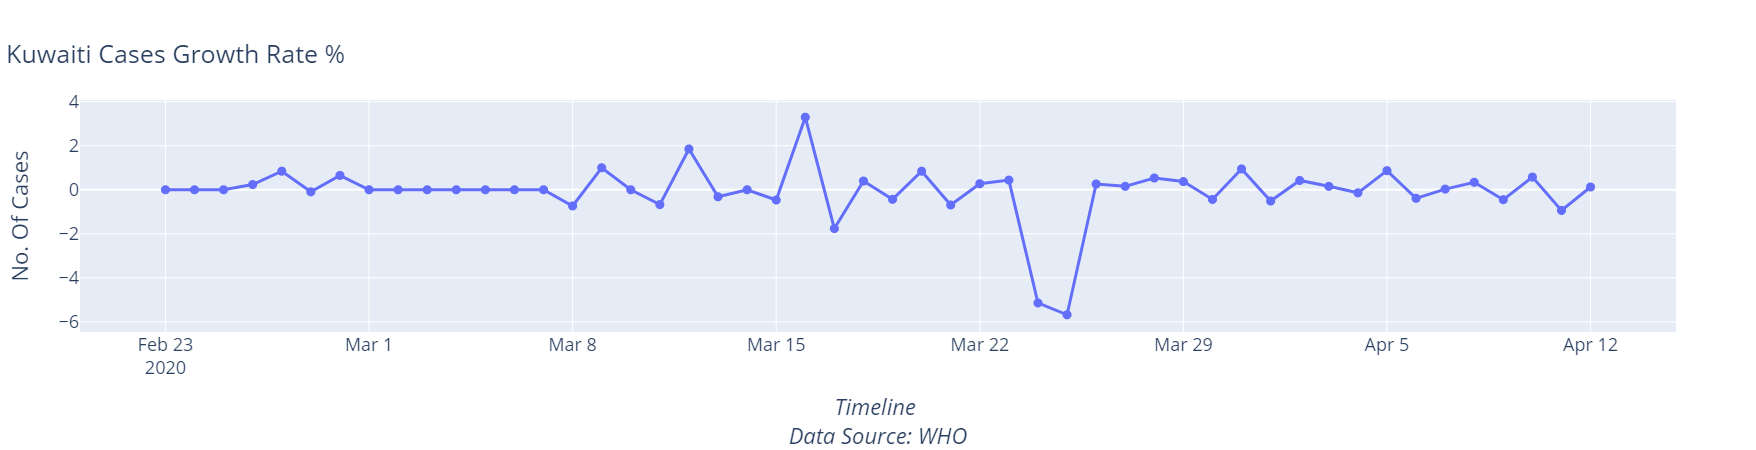

In [27]:
#hide_input
fig = go.Figure()

tmp_df = ku_df.copy()
tmp_df = tmp_df[tmp_df['Growth Rate Accel'] < 10]

fig.add_trace(go.Scatter(x=tmp_df['Date'], 
                         y=tmp_df['Growth Rate Accel'],
                         mode='lines+markers',
                         name='Growth Acceleration',
                         #line=dict(color='Green', width=3)
                         ))
# Configure other layout properties
fig.update_layout(
    title={'text': 'Kuwaiti Cases Growth Rate %', 'y':0.9, 'x':0.1, 'xanchor': 'center', 'yanchor': 'top'},
    xaxis=dict(
        title='<i>Timeline <br>Data Source: WHO</i>',
    ),
    yaxis=dict(
        title='No. Of Cases',
    ),
   )
fig.show()

### Kuwait Model

In [28]:
#hide
confirmed_by_country_df = full_df.groupby(['Date', 'Country']).sum().reset_index()

Model fit score: 0.99
Growth rate: 0.103


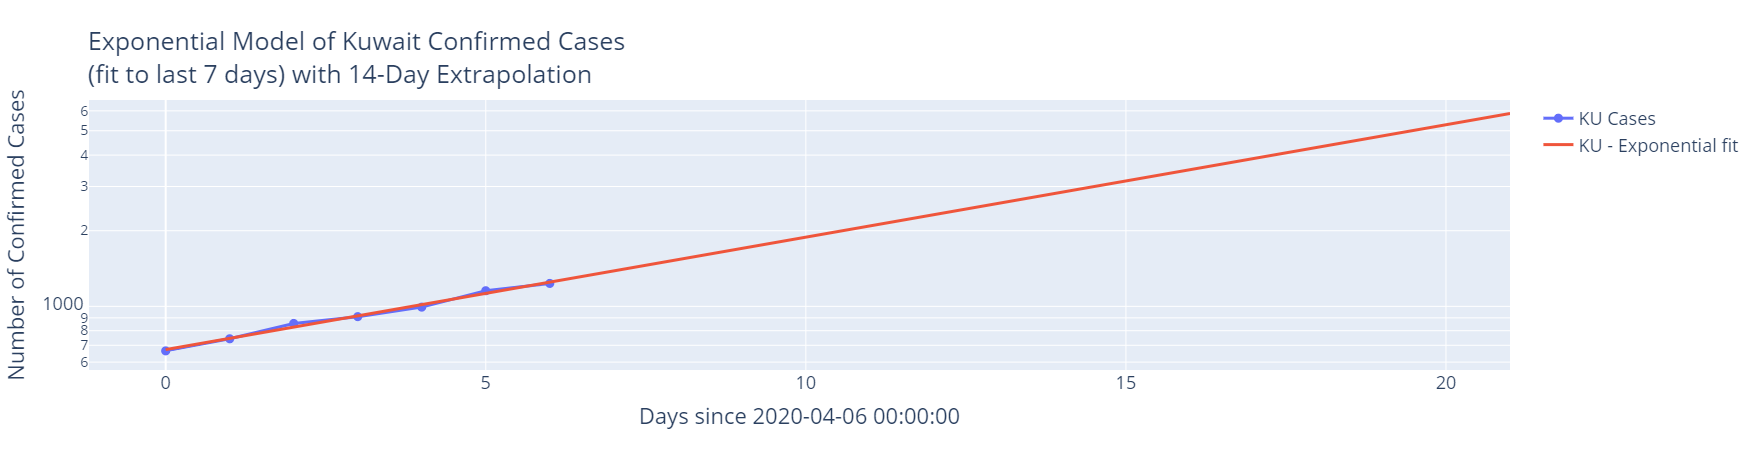

In [29]:
#hide_input

from sklearn.linear_model import LinearRegression

us_growth_rates = {}


n_days_to_fit = 7
confirmed_us_df = confirmed_by_country_df[(confirmed_by_country_df['Country'] == 'Kuwait') & (confirmed_by_country_df['Date'] >= (np.datetime64('today') - np.timedelta64(n_days_to_fit,'D')))]

x = (confirmed_us_df['Date'] - confirmed_us_df['Date'].min()).dt.days.to_numpy().reshape(-1, 1)
y = np.log(confirmed_us_df['Confirmed'])
reg = LinearRegression().fit(x, y)
print(f"Model fit score: {reg.score(x, y):.2f}")
print(f"Growth rate: {reg.coef_[0]:.3f}")
us_growth_rates[n_days_to_fit] = reg.coef_[0]

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=x[:,0],
        y=np.exp(y),
        name='KU Cases'
    )
)

xx = np.linspace(0, len(x[:,0]) + 14, 100)  # Forecast 14 days out
yy = reg.predict(xx.reshape(-1,1))

fig.add_trace(
    go.Scatter(
        x=xx,
        y=np.exp(yy),
        name='KU - Exponential fit',
        mode='lines',
    )
)

fig.update_layout(
    title=f"Exponential Model of Kuwait Confirmed Cases<br>(fit to last {n_days_to_fit} days) with 14-Day Extrapolation",
    xaxis_title=f"Days since {confirmed_us_df['Date'].min()}",
    yaxis_title="Number of Confirmed Cases",
    yaxis_type="log",
    #**k_layout_kwargs,
)

fig.show()

Model fit score: 0.98
Growth rate: 0.106


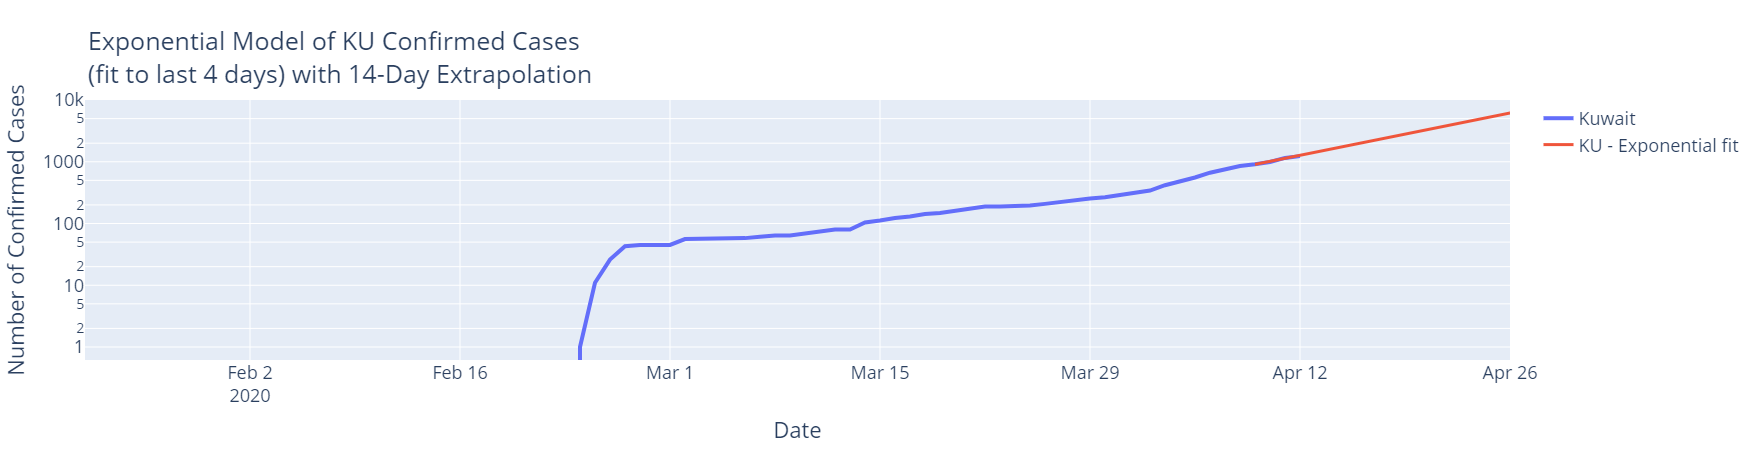

In [30]:
#hide_input

n_days_to_fit = 4
confirmed_us_df = confirmed_by_country_df[(confirmed_by_country_df['Country'] == 'Kuwait') & (confirmed_by_country_df['Date'] >= (np.datetime64('today') - np.timedelta64(n_days_to_fit,'D')))]

x = (confirmed_us_df['Date'] - confirmed_us_df['Date'].min()).dt.days.to_numpy().reshape(-1, 1)
y = np.log(confirmed_us_df['Confirmed'])
reg = LinearRegression().fit(x, y)
print(f"Model fit score: {reg.score(x, y):.2f}")
print(f"Growth rate: {reg.coef_[0]:.3f}")
us_growth_rates[n_days_to_fit] = reg.coef_[0]

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=confirmed_by_country_df[confirmed_by_country_df['Country'] == 'Kuwait']['Date'],
        y=confirmed_by_country_df[confirmed_by_country_df['Country'] == 'Kuwait']['Confirmed'],
        name='Kuwait',
        line=dict(width=4)
    )
)

predict_days_out = 7*2

exponential_fit_date_range = pd.date_range(confirmed_us_df['Date'].min(), confirmed_us_df['Date'].max() + np.timedelta64(predict_days_out,'D'))

xx = np.linspace(0, len(x[:,0]) + predict_days_out, exponential_fit_date_range.shape[0])  # Forecast 14 days out
yy = reg.predict(xx.reshape(-1,1))

fig.add_trace(
    go.Scatter(
        x=exponential_fit_date_range,
        y=np.exp(yy),
        name='KU - Exponential fit',
        mode='lines'
    )
)

fig.update_layout(
    title=f"Exponential Model of KU Confirmed Cases<br>(fit to last {n_days_to_fit} days) with {predict_days_out}-Day Extrapolation",
    xaxis_title=f"Date",
    yaxis_title="Number of Confirmed Cases",
    yaxis_type="log",
    #**k_layout_kwargs,
)

fig.show()

### Using Saudi as proxy model

Model fit score: 0.95
Growth rate: 0.128


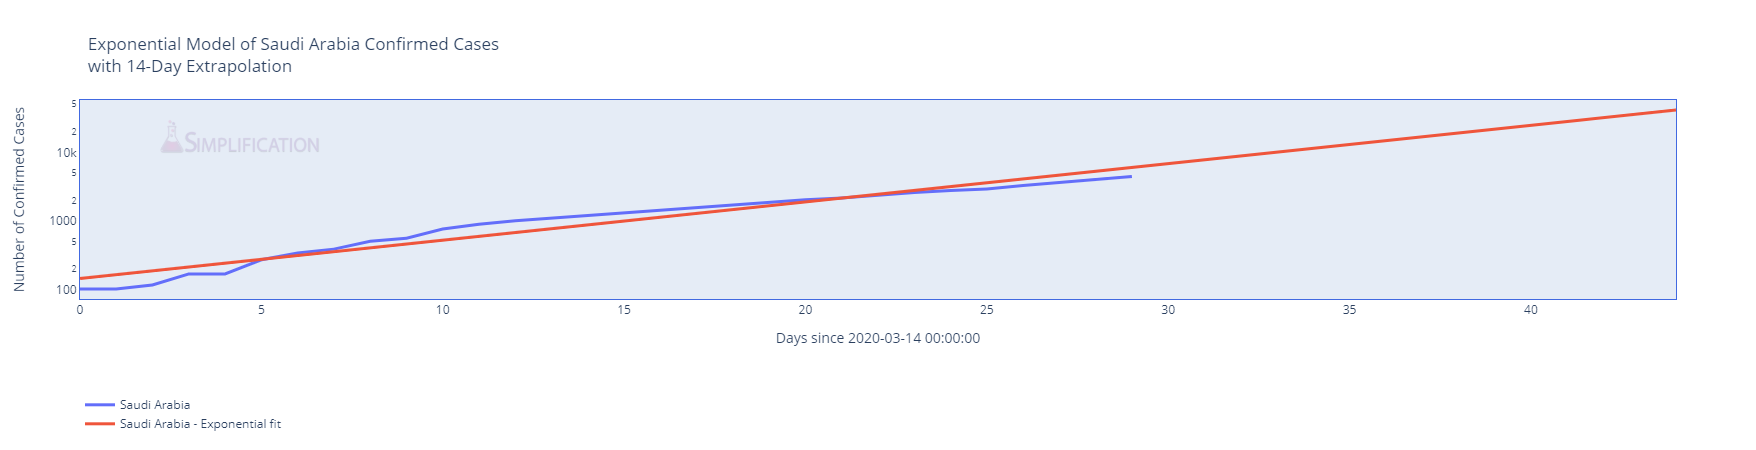

In [31]:
#hide_input

proxy_country = 'Saudi Arabia'

confirmed_iran_df = confirmed_by_country_df[(confirmed_by_country_df['Country'] == proxy_country) & (confirmed_by_country_df['Confirmed'] >= 100)]

x = (confirmed_iran_df['Date'] - confirmed_iran_df['Date'].min()).dt.days.to_numpy().reshape(-1, 1)
y = np.log(confirmed_iran_df['Confirmed'])
reg = LinearRegression().fit(x, y)
print(f"Model fit score: {reg.score(x, y):.2f}")
print(f"Growth rate: {reg.coef_[0]:.3f}")
iran_growth_rate = reg.coef_[0]

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=x[:,0],
        y=np.exp(y),
        name=proxy_country
    )
)

xx = np.linspace(0, len(x[:,0]) + 14, 100)  # Forecast 14 days out
yy = reg.predict(xx.reshape(-1,1))

fig.add_trace(
    go.Scatter(
        x=xx,
        y=np.exp(yy),
        name=f'{proxy_country} - Exponential fit'
    )
)

fig.update_layout(
    title=f"Exponential Model of {proxy_country} Confirmed Cases<br>with 14-Day Extrapolation",
    xaxis_title=f"Days since {confirmed_iran_df['Date'].min()}",
    yaxis_title="Number of Confirmed Cases",
    yaxis_type="log",
    **k_layout_kwargs,
)

fig.show()

### Applying the proxy model to the Kuwait

In [32]:
#hide


def linear_model(x, a, b):
    return b * x + a


def linear_model_fixed_slope(slope):
    def func(x, intercept):
        return linear_model(x, a=intercept, b=slope)
    
    return func

test_model = linear_model_fixed_slope(2)
x = np.array([1, 2, 3])
test_model(x=x, intercept=2)

array([4, 6, 8])

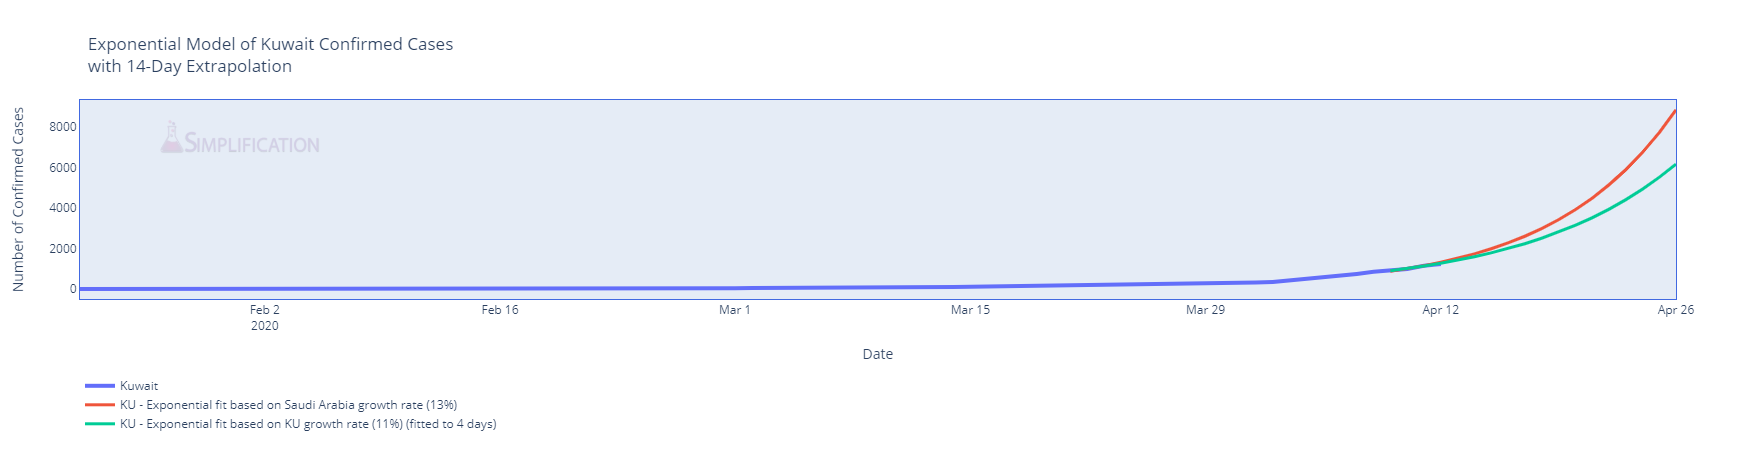

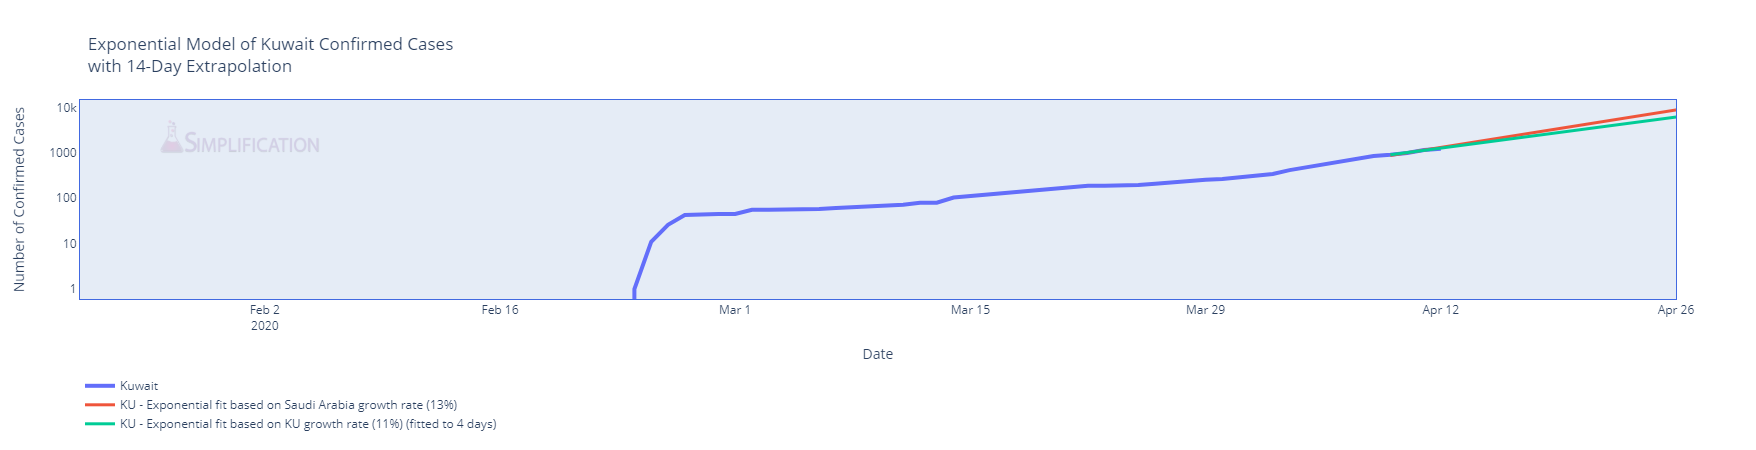

In [33]:
#hide_input

from scipy.optimize import curve_fit


def get_model(model, popt):
    def fitted_model(x):
        return model(x, *popt)
    return fitted_model


x = (confirmed_us_df['Date'] - confirmed_us_df['Date'].min()).dt.days.to_numpy()
y = np.log(confirmed_us_df['Confirmed'].to_numpy())

# Pull the slope from the Iran model and use for the U.S., allowing only the intercept to vary
model = linear_model_fixed_slope(iran_growth_rate)
popt, pcov = curve_fit(model, x, y)

fitted_model_iran_rate = get_model(model, popt)

# Now do the same using the slope from the US model
us_growth_rate_n_days_to_fit = 4

model = linear_model_fixed_slope(us_growth_rates[us_growth_rate_n_days_to_fit])
popt, pcov = curve_fit(model, x, y)

fitted_model_us_rate = get_model(model, popt)

# Plot results
for layout_kwargs in [{}, {"yaxis_type": "log"}]:
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=confirmed_by_country_df[confirmed_by_country_df['Country'] == 'Kuwait']['Date'],
            y=confirmed_by_country_df[confirmed_by_country_df['Country'] == 'Kuwait']['Confirmed'],
            name='Kuwait',
            line=dict(width=4)
        )
    )

    exponential_fit_date_range = pd.date_range(confirmed_us_df['Date'].min(), confirmed_us_df['Date'].max() + np.timedelta64(14,'D'))

    xx = np.linspace(0, len(x) + 14, exponential_fit_date_range.shape[0])  # Forecast 14 days out
    yy = fitted_model_iran_rate(xx)

    fig.add_trace(
        go.Scatter(
            x=exponential_fit_date_range,
            y=np.exp(yy),
            name=f'KU - Exponential fit based on {proxy_country} growth rate ({iran_growth_rate:.0%})',
            mode='lines'
        )
    )

    #########

    yy = fitted_model_us_rate(xx)

    fig.add_trace(
        go.Scatter(
            x=exponential_fit_date_range,
            y=np.exp(yy),
            name=f'KU - Exponential fit based on KU growth rate ({us_growth_rates[us_growth_rate_n_days_to_fit]:.0%}) (fitted to {us_growth_rate_n_days_to_fit} days)',
            mode='lines'
        )
    )

    fig.update_layout(
        title="Exponential Model of Kuwait Confirmed Cases<br>with 14-Day Extrapolation",
        xaxis_title="Date",
        yaxis_title="Number of Confirmed Cases",
        **k_layout_kwargs,
        **layout_kwargs
    )

    fig.show()

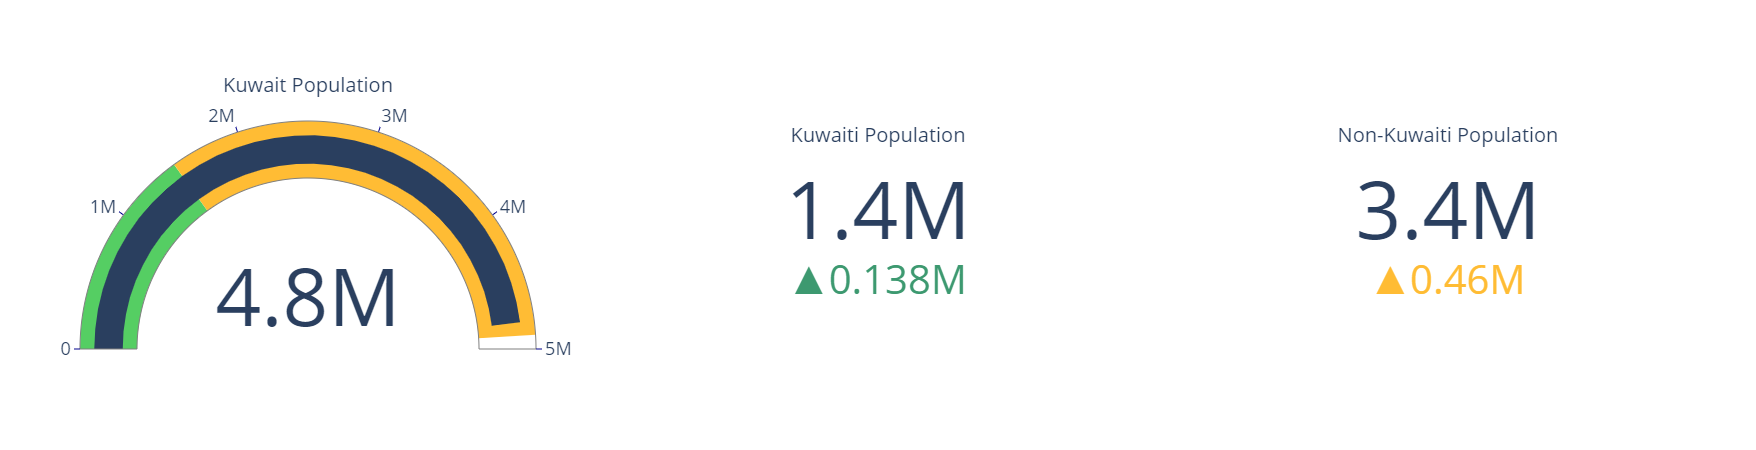

In [34]:
fig = go.Figure()

fig.add_trace(go.Indicator(
    
    value = 4800000,
    #delta = {'reference': 4207083},
    #gauge = {'axis': {'visible': False}},
    domain = {'row': 0, 'column': 0},
    title = 'Kuwait Population',
    gauge = {
        'axis': {'range': [None, 5000000], 'tickwidth': 1, 'tickcolor': "darkblue"},
        'bar': {'color': '#2a3f5f'},
        'bgcolor': "white",
        'borderwidth': 1,
        'bordercolor': "gray",
        'steps': [
            {'range': [1, 1500000], 'color': '#55ce63'},
            {'range': [1500000, 4900000], 'color': '#ffbc34'}],
        'threshold': {
            'line': {'color': "red", 'width': 0},
            'thickness': 0.75,
            'value': 95000}}
))
fig.add_trace(go.Indicator(
    mode = "number+delta",
    value = 1400000,
    delta = {'reference': 1262124.9},
    domain = {'row': 0, 'column': 1},
    title = {'text': "Kuwaiti Population"}))

fig.add_trace(go.Indicator(
    mode = "number+delta",
    value = 3400006,
    delta = {'reference': 2944958.1, 'increasing': {'color': '#ffbc34'}},    
    domain = {'row': 0, 'column': 2},
    title = {'text': "Non-Kuwaiti Population"}))

fig.update_layout(
    #paper_bgcolor = "lavender", font = {'color': "darkblue", 'family': "Arial"},
    grid = {'rows': 1, 'columns': 3, 'pattern': "independent"},
    template = {
        'data' : {'indicator': 
                  [
                      {
                          'mode' : "number+gauge",
                      }
                  ]
                 }
    }
)

In [35]:
#hide

from fbprophet.plot import plot_plotly
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

In [36]:
#hide

full_pop = 4.5e6 #330e6

#floor_model = lambda x: max(x - 1, 0)  # Use the value itself because the function only increases
floor_model = lambda x: round(0.65 * x)
cap_model = lambda x: round(min(full_pop, 1.5 * x + 10000))  # 50% above plus one to ensure floor > cap at 0

# Modeling Iran confirmed cases 
confirmed_training_df = confirmed_by_country_df[(confirmed_by_country_df['Country'] == 'Kuwait') & (confirmed_by_country_df['Confirmed'] > 0)]
confirmed_training_df = confirmed_training_df.rename(columns={'Date': 'ds', 'Confirmed': 'y'}).reset_index(drop=True)

confirmed_training_df['floor'] = confirmed_training_df.y.apply(floor_model)
confirmed_training_df['cap'] = confirmed_training_df.y.apply(cap_model)

In [37]:
#hide

confirmed_training_df.y = confirmed_training_df.y.apply(np.log10)
confirmed_training_df.floor = confirmed_training_df.floor.apply(np.log10)
confirmed_training_df.cap = confirmed_training_df.cap.apply(np.log10)

In [38]:
#hide

# Total confirmed model 
m = Prophet(
    growth='linear',
    #interval_width=0.90,
    changepoint_prior_scale=0.05,
    changepoint_range=0.9,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    #n_changepoints=2
)
m.fit(confirmed_training_df)
future = m.make_future_dataframe(periods=14)
future['floor'] = confirmed_training_df.floor
future['cap'] = confirmed_training_df.cap
confirmed_forecast = m.predict(future)

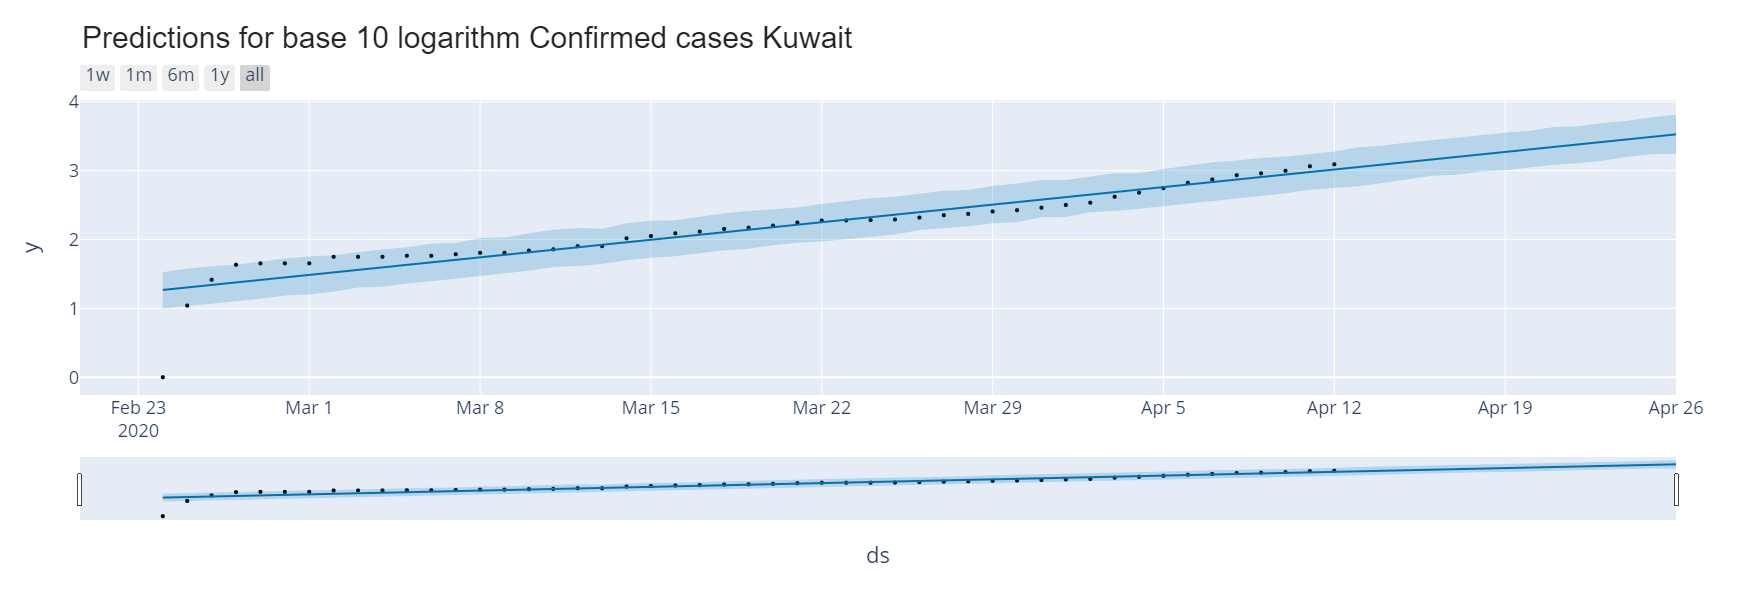

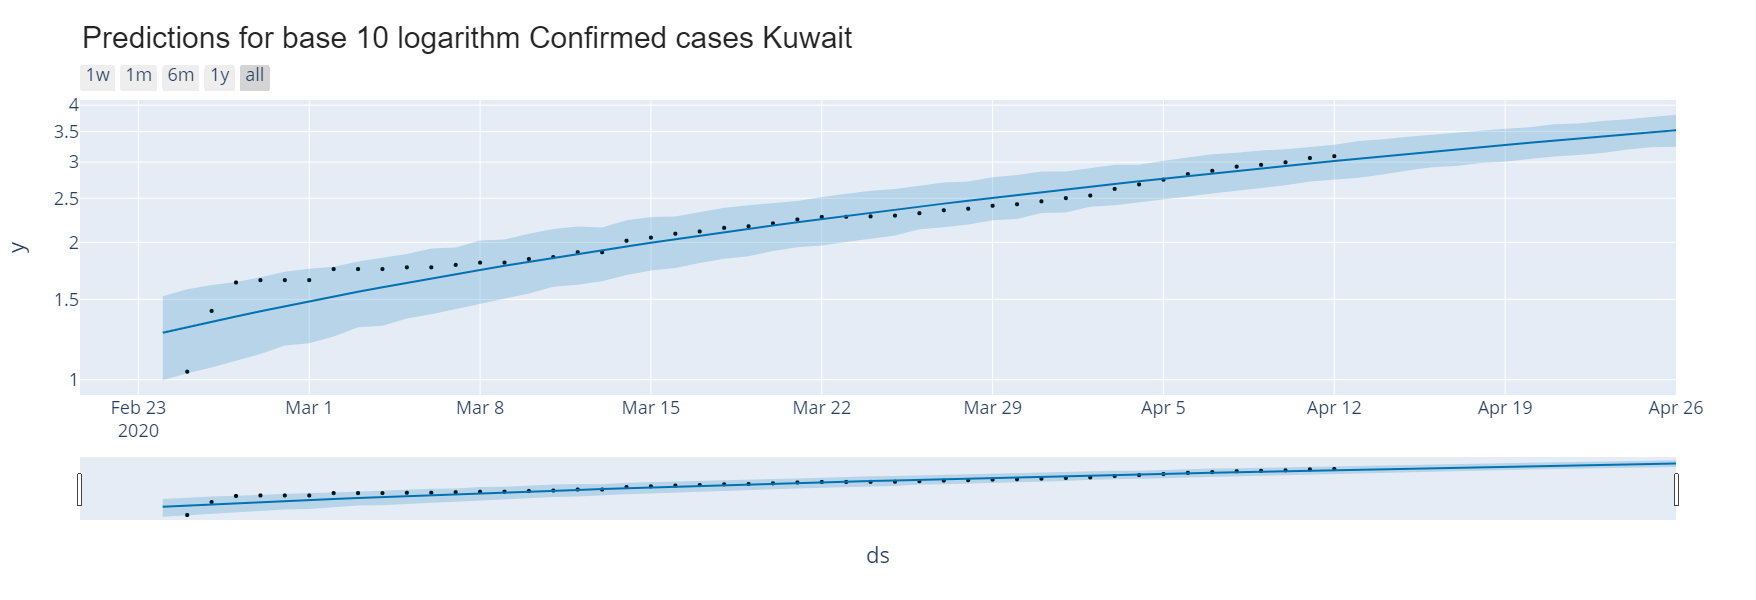

In [39]:
#hide_input

for kwargs in [{}, {"yaxis_type": "log"}]:
    fig = plot_plotly(m, confirmed_forecast, plot_cap=False, changepoints=True)
    annotations = []
    annotations.append(dict(
        xref='paper',
        yref='paper',
        x=0.0,
        y=1.15,
        xanchor='left',
        yanchor='bottom',
        text='Predictions for base 10 logarithm Confirmed cases Kuwait',
        font=dict(
            family='Arial',
            size=30,
            color='rgb(37,37,37)'),
        showarrow=False))
    fig.update_layout(
        annotations=annotations,
        **kwargs
    )
    fig.show()

NOTE: The y-axis above is the log of the number of cases. So let's rescale that.

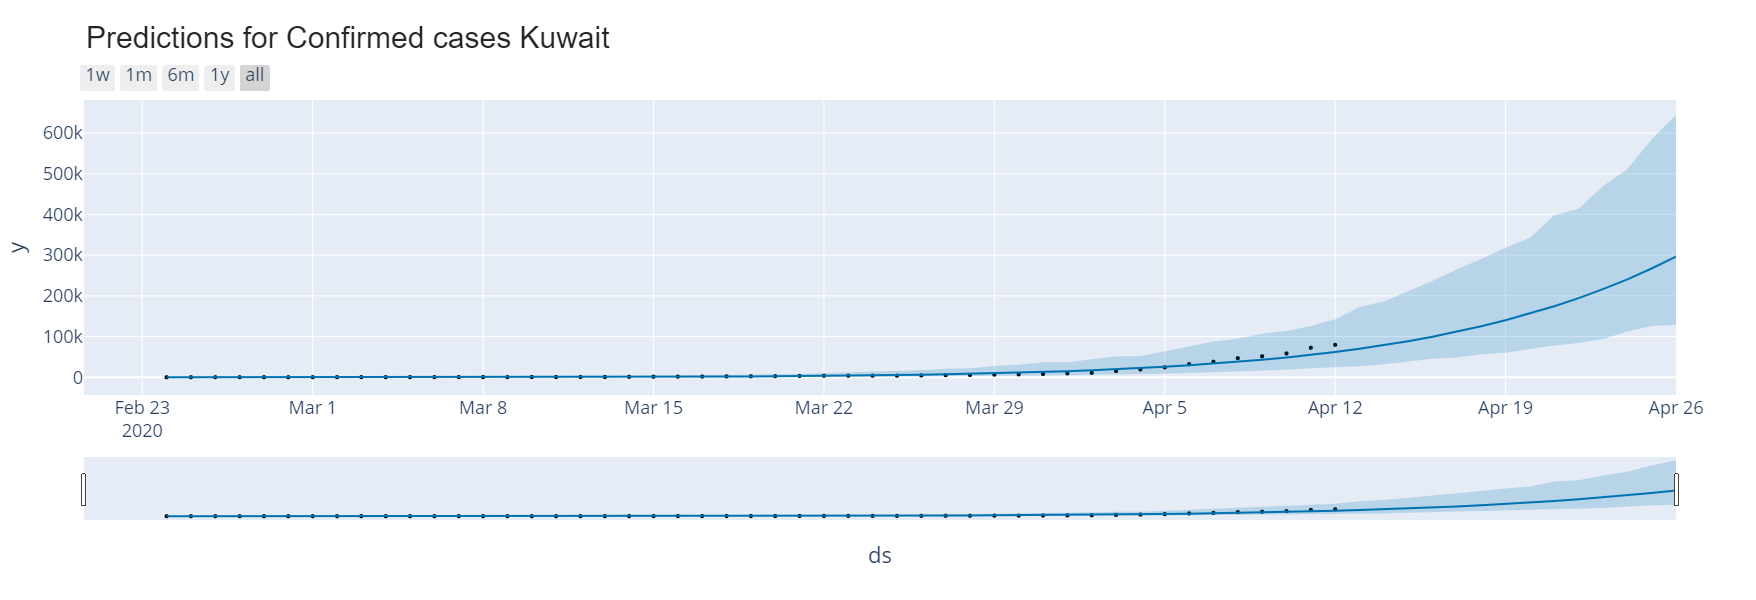

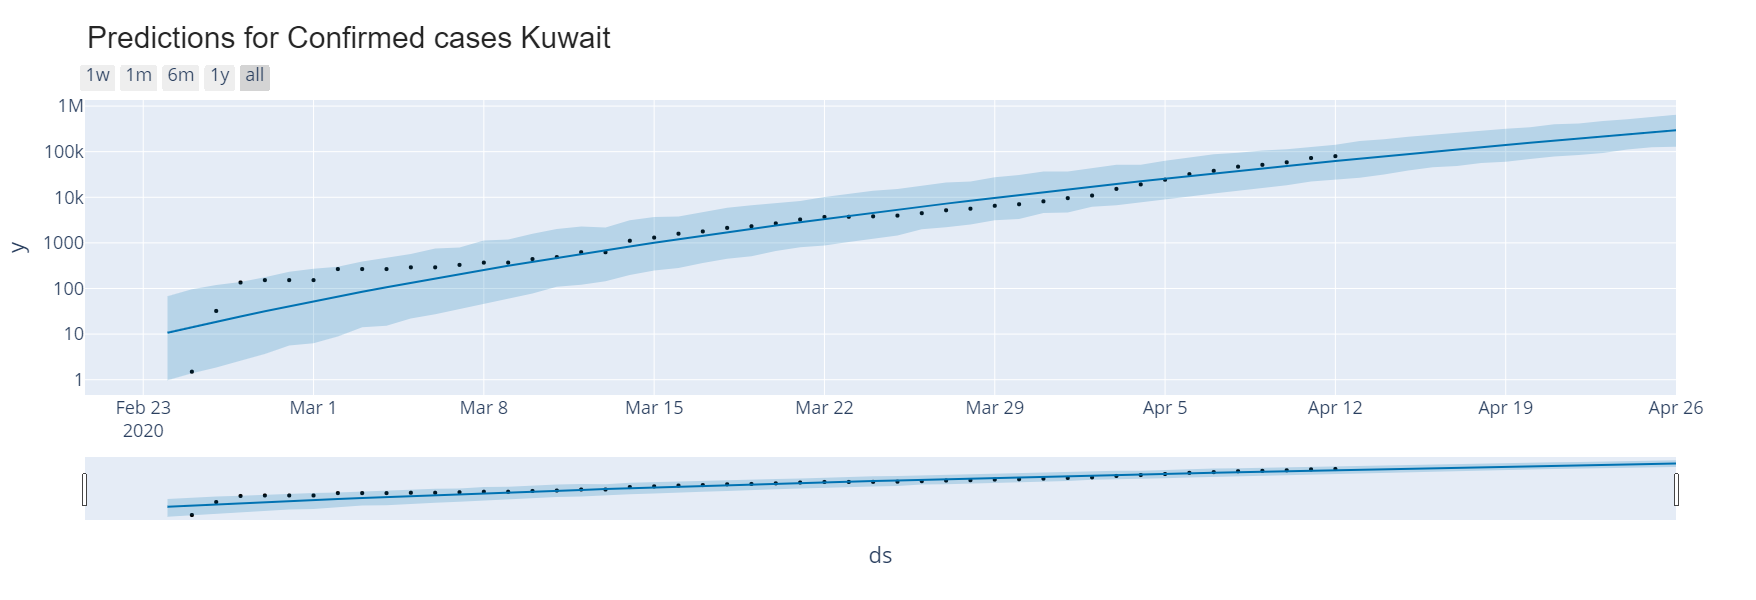

In [40]:
#hide_input

for kwargs in [{}, {"yaxis_type": "log"}]:
    fig = plot_plotly(m, confirmed_forecast, plot_cap=False, changepoints=True)
    annotations = []
    annotations.append(dict(
        xref='paper',
        yref='paper',
        x=0.0,
        y=1.15,
        xanchor='left',
        yanchor='bottom',
        text='Predictions for Confirmed cases Kuwait',
        font=dict(
            family='Arial',
            size=30,
            color='rgb(37,37,37)'),
        showarrow=False))
    fig.update_layout(
        annotations=annotations,
        **kwargs
    )
    for trace in fig.data:
        trace.y = np.power(trace.y, 10)
    fig.show()

[^1]: Source: ["COVID-19 Data Repository by Johns Hopkins CSSE"](https://systems.jhu.edu/research/public-health/ncov/)

### Copyright

Copyright © 2020 by [Nabeel Khan](https://www.nabeelkhan.com/contact/):e-mail:[^1]
- [Twitter](https://www.twitter.com/TheNabeelKhan)
- [LinkedIn](https://www.linkedin.com/in/NabeelKhan)


All rights reserved. No part of this publication may be reproduced, distributed, or transmitted in any form or by any means, including photocopying, recording, or other electronic or mechanical methods, without the prior written permission of the Author, except in the case of brief quotations embodied in critical reviews and certain other noncommercial uses permitted by copyright law. For permission requests, write to the publisher, addressed “Attention: Permissions Coordinator,” at the Author's Website.


[Simplification.io](https://www.Simplification.io)
*A Data Science Company*

- [Twitter](https://www.twitter.com/iSimplification)
- [LinkedIn](https://www.linkedin.com/company/simplification)
- [Messenger](http://m.me/iSimplification)
- [Facebook](https://www.facebook.com/iSimplification)
- Pinterest : iSimplification
- Instagram : iSimplification